
model = keras.models.load_model('./PyOut/Models1/')
model1 = keras.models.load_model('./PyOut/Models/')

In [3]:
from tensorflow import keras

from keras import backend as K
from keras.callbacks import EarlyStopping


import pandas as pd
import datetime as dt
import numpy as np

import time
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence
from matplotlib.pyplot import figure
import shap
import tensorflow.keras.backend 

from nltk import ngrams
import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

import sys
#sys.path.insert(0, r"c:\users\ishaa\anaconda3\envs\tf_gpu\lib\site-packages")

from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers

import shap
import tensorflow.keras.backend 
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD
from keras import Sequential

In [4]:

df=pd.read_csv('./PyOut/session_level_ppcrsdall_0104.csv', sep=',', keep_default_na=False)

In [5]:
df.head()

,SessionID,page_count,session_time,avg_time_per_page,twograms,aanvragen ww,home aanvragen,home home,home inschrijven,home mijn_berichten,...,total_timespent_per_page|vacatures,total_timespent_per_page|vacatures_bij_mijn_cv,total_timespent_per_page|vacatures_zoeken,total_timespent_per_page|werkmap,CustomerID,AgeCategory,Gender,Office_U,Office_W,Flag
0,4752535,2,104.0,52.000000,inschrijven inschrijven,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2140620,30-39,V,271,274,0
1,388094,117,6395.0,54.658120,taken taken taken mijn_cv mijn_cv inschrijven...,61,0,0,0,0,...,126.0,0.0,12.0,0.0,2099262,50-65,V,330,330,0
2,12239424,2,6.0,3.000000,inschrijven taken,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1626445,50-65,M,330,330,0
3,52132756,73,2410.0,33.013699,taken vacatures_zoeken vacatures_zoeken vacat...,0,0,0,0,0,...,0.0,404.0,1952.0,0.0,1288513,50-65,M,257,261,0
4,28434762,38,3067.0,80.710526,mijn_werkmap mijn_werkmap vacatures_bij_mijn_...,0,0,11,0,0,...,0.0,678.0,0.0,0.0,2057162,50-65,M,296,247,0


In [6]:
len(df['CustomerID'].unique())

1000

In [7]:
df_pc=(df.groupby(['page_count'])).agg(num_sessions=('SessionID', 'count')).reset_index()
total_sess = df.shape[0]

In [8]:

df_pc['perc_sess']=df_pc['num_sessions']/total_sess
df_pc.head(10)

,page_count,num_sessions,perc_sess
0,1,3082,0.072117
1,2,3094,0.072398
2,3,4217,0.098676
3,4,4158,0.097295
4,5,3713,0.086882
5,6,3017,0.070596
6,7,2469,0.057773
7,8,2051,0.047992
8,9,1798,0.042072
9,10,1540,0.036035


In [9]:


session_with_flags=df.copy()

session_with_flags.loc[:,'twograms'] =  session_with_flags.loc[:,'twograms'].astype(str)
session_with_flags.loc[:,'CustomerID'] =  session_with_flags.loc[:,'CustomerID'].astype(str)
session_with_flags.loc[:,'Gender'] =  session_with_flags.loc[:,'Gender'].astype(str)
session_with_flags.loc[:,'Office_U'] =  session_with_flags.loc[:,'Office_U'].astype(str)
session_with_flags.loc[:,'Office_W'] =  session_with_flags.loc[:,'Office_W'].astype(str)
session_with_flags.loc[:,'Flag'] =  session_with_flags.loc[:,'Flag'].astype(str)

cols=session_with_flags.filter(regex=(".*timespent.*")).columns
# 
for c in cols:
    session_with_flags.loc[:,c] =  session_with_flags.loc[:,c].replace('',0.0)
    session_with_flags.loc[:,c] =  session_with_flags.loc[:,c].astype('float16')
#     del session_with_flags[c]
    print(c)
#     print(session_with_flags.loc[:,c].values == '').sum()


# In[39]:



encoder = LabelEncoder()
#  transfomed_label = encoder.fit_transform(["dog", "cat", "bird"])

# del (session_with_flags['SessionID'])
# session_with_flags.loc[:,'twograms'] =  encoder.fit_transform(session_with_flags.loc[:,'twograms'])
# session_with_flags.loc[:,'twograms'] =  session_with_flags.loc[:,'twograms'].astype('float16')

session_with_flags = session_with_flags.drop(['twograms'], axis=1)

# session_with_flags.loc[:,'CustomerID'] =  session_with_flags.loc[:,'CustomerID'].astype(str)
session_with_flags.loc[:,'CustomerID'] =  encoder.fit_transform(session_with_flags.loc[:,'CustomerID'])
# session_with_flags.loc[:,'CustomerID'] =  session_with_flags.loc[:,'CustomerID'].astype('float16')

session_with_flags.loc[:,'AgeCategory'] =  encoder.fit_transform(session_with_flags.loc[:,'AgeCategory'])
# session_with_flags.loc[:,'AgeCategory'] =  session_with_flags.loc[:,'AgeCategory'].astype('float16')

session_with_flags.loc[:,'Gender'] =  encoder.fit_transform(session_with_flags.loc[:,'Gender'])
# session_with_flags.loc[:,'Gender'] =  session_with_flags.loc[:,'Gender'].astype(int)

# session_with_flags.loc[:,'Office_U'] =  session_with_flags.loc[:,'Office_U'].astype(str)
session_with_flags.loc[:,'Office_U'] =  encoder.fit_transform(session_with_flags.loc[:,'Office_U'])
# session_with_flags.loc[:,'Office_U'] =  session_with_flags.loc[:,'Office_U'].astype('float16')

# session_with_flags.loc[:,'Office_W'] =  session_with_flags.loc[:,'Office_W'].astype(str)
session_with_flags.loc[:,'Office_W'] =  encoder.fit_transform(session_with_flags.loc[:,'Office_W'])
# session_with_flags.loc[:,'Office_W'] =  session_with_flags.loc[:,'Office_W'].astype('float16')

session_with_flags.loc[:,'Flag'] =  encoder.fit_transform(session_with_flags.loc[:,'Flag'])
# session_with_flags.loc[:,'Flag'] =  session_with_flags.loc[:,'Flag'].astype('float16')

print(session_with_flags.dtypes[session_with_flags.dtypes=='object'])


# In[40]:


session_with_flags.loc[:,'page_count'] =  session_with_flags.loc[:,'page_count'].astype('float16')
session_with_flags.loc[:,'session_time'] =  session_with_flags.loc[:,'page_count'].astype('float16')
session_with_flags.loc[:,'avg_time_per_page'] =  session_with_flags.loc[:,'avg_time_per_page'].astype('float16')

session_with_flags = session_with_flags.drop(['SessionID'], axis=1)


mean_timespent_per_page|aanvragen-ww
mean_timespent_per_page|home
mean_timespent_per_page|inschrijven
mean_timespent_per_page|mijn_berichten
mean_timespent_per_page|mijn_cv
mean_timespent_per_page|mijn_documenten
mean_timespent_per_page|mijn_sollicitaties
mean_timespent_per_page|mijn_werkmap
mean_timespent_per_page|taken
mean_timespent_per_page|vacatures
mean_timespent_per_page|vacatures_bij_mijn_cv
mean_timespent_per_page|vacatures_zoeken
mean_timespent_per_page|werkmap
total_timespent_per_page|aanvragen-ww
total_timespent_per_page|home
total_timespent_per_page|inschrijven
total_timespent_per_page|mijn_berichten
total_timespent_per_page|mijn_cv
total_timespent_per_page|mijn_documenten
total_timespent_per_page|mijn_sollicitaties
total_timespent_per_page|mijn_werkmap
total_timespent_per_page|taken
total_timespent_per_page|vacatures
total_timespent_per_page|vacatures_bij_mijn_cv
total_timespent_per_page|vacatures_zoeken
total_timespent_per_page|werkmap
Series([], dtype: object)


In [10]:


# 3 way split
msk = np.random.rand(len(session_with_flags)) < 0.8
train = session_with_flags[msk]
val_test = session_with_flags[~msk]

msk = np.random.rand(len(val_test)) < 0.5
validate = val_test[msk]
test = val_test[~msk]

train_target = train.loc[:,"Flag"]
validate_target = validate.loc[:,"Flag"]
test_target = test.loc[:,"Flag"]

print(len(train[train.Flag==1]),len(train)) #Sessions with flag =1 
print(len(validate[validate.Flag==1]),len(validate)) #Sessions with flag =1 
print(len(test[test.Flag==1]),len(test)) #Sessions with flag =1 

train_data = train.drop(['Flag'], axis=1)
validate_data = validate.drop(['Flag'], axis=1)
test_data = test.drop(['Flag'], axis=1)

3913 34303
496 4211
485 4222


In [11]:
# 2 way split - Train & Validate
msk = np.random.rand(len(session_with_flags)) < 0.7
train = session_with_flags[msk]
validate = session_with_flags[~msk]

# msk = np.random.rand(len(val_test)) < 0.5
# validate = val_test[msk]
# test = val_test[~msk]

train_target = train.loc[:,"Flag"]
validate_target = validate.loc[:,"Flag"]
# test_target = test.loc[:,"Flag"]

print(len(train[train.Flag==1]),len(train)) #Sessions with flag =1 
print(len(validate[validate.Flag==1]),len(validate)) #Sessions with flag =1 
# print(len(test[test.Flag==1]),len(test)) #Sessions with flag =1 

train_data = train.drop(['Flag'], axis=1)
validate_data = validate.drop(['Flag'], axis=1)
# test_data = test.drop(['Flag'], axis=1)

3418 29804
1476 12932


In [12]:
print(len(train[train.Flag==1])/len(train))
print(len(validate[validate.Flag==1])/len(validate))
# print(len(test[test.Flag==1])/len(test))

0.11468259294054489
0.11413547788431797


In [13]:
train_pc=(train.groupby(['page_count'])).agg(num_sessions=('CustomerID', 'count')).reset_index()
train_sess = train.shape[0]
train_pc['perc_sess']=train_pc['num_sessions']/train_sess
train_pc.head(10)

,page_count,num_sessions,perc_sess
0,1.0,2153,0.072239
1,2.0,2166,0.072675
2,3.0,2911,0.097671
3,4.0,2917,0.097873
4,5.0,2559,0.085861
5,6.0,2098,0.070393
6,7.0,1716,0.057576
7,8.0,1457,0.048886
8,9.0,1251,0.041974
9,10.0,1078,0.036170


In [14]:
validate_pc=(validate.groupby(['page_count'])).agg(num_sessions=('CustomerID', 'count')).reset_index()
validate_sess = validate.shape[0]
validate_pc['perc_sess']=validate_pc['num_sessions']/validate_sess
validate_pc.head(10)

,page_count,num_sessions,perc_sess
0,1.0,929,0.071837
1,2.0,928,0.071760
2,3.0,1306,0.100990
3,4.0,1241,0.095964
4,5.0,1154,0.089236
5,6.0,919,0.071064
6,7.0,753,0.058228
7,8.0,594,0.045933
8,9.0,547,0.042298
9,10.0,462,0.035725


In [15]:
test_pc=(test.groupby(['page_count'])).agg(num_sessions=('CustomerID', 'count')).reset_index()
test_sess = test.shape[0]
test_pc['perc_sess']=test_pc['num_sessions']/test_sess
test_pc.head(10)

,page_count,num_sessions,perc_sess
0,1.0,308,0.072951
1,2.0,290,0.068688
2,3.0,439,0.103979
3,4.0,423,0.100189
4,5.0,394,0.093321
5,6.0,280,0.066319
6,7.0,240,0.056845
7,8.0,192,0.045476
8,9.0,169,0.040028
9,10.0,145,0.034344


In [16]:

# train_data = np.reshape(train_data,( train_data.shape[0], 1,train_data.shape[1]))
train_data.shape
# 

(29804, 203)

In [17]:


def recall_m(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall

def precision_m(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision

def f1_m(y_true, y_pred): 
    precision = precision_m(y_true, y_pred) 
    recall = recall_m(y_true, y_pred) 
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [18]:
from keras import backend as K
def precision_threshold(threshold=0.5):
    def precision(y_true, y_pred):
        """Precision metric.
        Computes the precision over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # count the predicted positives
        predicted_positives = K.sum(y_pred)
        # Get the precision ratio
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        """Recall metric.
        Computes the recall over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # Compute the number of positive targets.
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

In [19]:
# !pip install keras-self-attention
# from keras_self_attention import SeqSelfAttention


# TrainX= np.reshape(TrainX,(TrainX.shape[0], 1, TrainX.shape[1]))

# train_data = np.reshape(train_data,( 1, train_data.shape[0], train_data.shape[1]))

number_of_features = train_data.shape[1]

# # Start neural network
network = Sequential()

# # Add fully connected layer with a ReLU activation function
network.add(layers.InputLayer(input_shape=(number_of_features,)))
# network.add(layers.Dense(units=8, activation='relu', input_shape=(number_of_features,)))
# network.add(layers.Dense(units=250, activation='relu'))


# network.add(keras.layers.Reshape((1, number_of_features)))

# network.add(layers.recurrent.LSTM(100, implementation=2, kernel_initializer='glorot_uniform',return_sequences=False,activation="tanh", dropout=0.2, recurrent_dropout=0.0))
# # network.add(layers.recurrent.LSTM(100, return_sequences=False, dropout=0.2, input_shape=(8,number_of_features)))
# #https://github.com/fau-is/next-best-action/blob/master/nextbestaction/train.py
network.add(layers.normalization.BatchNormalization())
# # Add fully connected layer with a ReLU activation function
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=1000, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=1000, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=1000, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=1000, activation='relu'))

# network.add(layers.Dense(units=250, activation='relu'))
# network.add(layers.Dense(units=250, activation='relu'))
# network.add(SeqSelfAttention(attention_width=15,
#     attention_activation='sigmoid',
#     name='Attention',))


# # Add fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=1, activation='sigmoid')) #output layer for binary classification

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# optimizer=Adadelta(lr=.1.5)

network.compile(loss='binary_crossentropy', # Cross-entropy
                optimizer='adam', # Adam performs better than Adadelta and SGD
#                    optimizer = SGD(learning_rate=0.01, momentum=0.1, nesterov=False), 
#                 metrics=['accuracy']) # Accuracy performance metric
                metrics=[recall_m, precision_m,'acc',f1_m])
#                 metrics=[precision_threshold(0.1)])
#                 metrics=[precision_m])


In [20]:
# print("--- %s seconds for pre-processing  2---" % (time.time() - start_time))
start_time = time.time()

# validate_data = np.reshape(validate_data,( 1, validate_data.shape[0], validate_data.shape[1]))
class_weight = {0: 1.,
                1: 5.}

history = network.fit(train_data, # Features
                      train_target, # Target vector
                      epochs=100, # Number of epochs
                      verbose=1, # Print description after each epoch
                      batch_size=512, # Number of observations per batch
                      callbacks=early_stopping,
#                       class_weight=class_weight,
                      validation_data=(validate_data, validate_target)) # Data for evaluation

print("--- %s seconds for training---" % (time.time() - start_time))


# In[ ]:

network.save('./PyOut/Models_0104/'+str(time.time())+'/')
start_time = time.time()
# evaluate the model
loss, accuracy, f1_score, precision, recall = network.evaluate(test_data, test_target, verbose=1)
print("--- %s seconds for evaluation---" % (time.time() - start_time))

Epoch 1/100
59/59 [==============================] - 5s 80ms/step - loss: 0.3793 - recall_m: 0.0912 - precision_m: 0.3618 - acc: 0.8875 - f1_m: 0.1367 - val_loss: 0.3469 - val_recall_m: 0.5211 - val_precision_m: 0.6665 - val_acc: 0.9201 - val_f1_m: 0.5795
Epoch 2/100
59/59 [==============================] - 4s 74ms/step - loss: 0.2741 - recall_m: 0.2900 - precision_m: 0.7307 - acc: 0.9055 - f1_m: 0.4083 - val_loss: 0.3464 - val_recall_m: 0.5350 - val_precision_m: 0.7083 - val_acc: 0.9258 - val_f1_m: 0.6043
Epoch 3/100
59/59 [==============================] - 4s 75ms/step - loss: 0.2637 - recall_m: 0.3078 - precision_m: 0.7661 - acc: 0.9091 - f1_m: 0.4337 - val_loss: 0.2981 - val_recall_m: 0.5225 - val_precision_m: 0.7486 - val_acc: 0.9286 - val_f1_m: 0.6103
Epoch 4/100
59/59 [==============================] - 4s 74ms/step - loss: 0.2602 - recall_m: 0.3402 - precision_m: 0.7659 - acc: 0.9117 - f1_m: 0.4653 - val_loss: 0.2600 - val_recall_m: 0.5065 - val_precision_m: 0.7700 - val_acc: 0.

# loss, accuracy, f1_score, precision, recall = network.evaluate(test_data, test_target, verbose=1)
loss, precision = network.evaluate(test_data, test_target, verbose=1)
#loss: 0.3370 - precision: 0.1129

In [21]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 203)               812       
_________________________________________________________________
dropout (Dropout)            (None, 203)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              204000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1

In [22]:
pred_cnn_val_y = network.predict([validate_data], batch_size=1024, verbose=1)
# for thresh in [.43,0.58,0.65,.72,0.87]:
for thresh in [.35,0.38,0.41,.44,0.47]:
    thresh = np.round(thresh, 3)
#     print("F1 score at threshold {0} is {1}".format(thresh, metrics.recall_score(validate_target, (pred_cnn_val_y>thresh).astype(int))))
    print("Score at threshold {0} is {1}".format(thresh, metrics.f1_score(validate_target, (pred_cnn_val_y>thresh).astype(int))))




13/13 [==============================] - 0s 31ms/step
Score at threshold 0.35 is 0.6650246305418719
Score at threshold 0.38 is 0.660536962118426
Score at threshold 0.41 is 0.6552771450265755
Score at threshold 0.44 is 0.6462984723854288
Score at threshold 0.47 is 0.6337349397590362


In [23]:
pred_test_y = network.predict([test_data], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > 0.42).astype(int)

matrix = metrics.confusion_matrix(test_target, pred_test_y )

print(metrics.f1_score(test_target, pred_test_y ))
print(metrics.precision_score(test_target, pred_test_y ))
print(metrics.accuracy_score(test_target, pred_test_y ))
print(metrics.recall_score(test_target, pred_test_y ))

print(matrix)

5/5 [==============================] - 0s 22ms/step
0.6827033218785797
0.7680412371134021
0.9343912837517764
0.6144329896907217
[[3647   90]
 [ 187  298]]


[[3647   90]
 [ 187  298]]


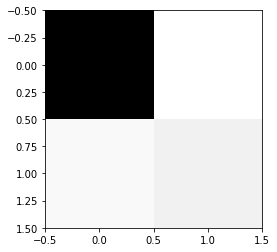

In [24]:
print(matrix)

import matplotlib.pyplot as plt
# conf = sklearn.metrics.confusion_matrix(y_true, y_pred)
plt.imshow(matrix, cmap='binary', interpolation='None')
plt.show()

In [25]:
pred_test_y = network.predict([validate_data], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > 0.27).astype(int)

matrix = metrics.confusion_matrix(validate_target, pred_test_y )

print(metrics.f1_score(validate_target, pred_test_y ))
print(metrics.precision_score(validate_target, pred_test_y ))
print(metrics.accuracy_score(validate_target, pred_test_y ))
print(metrics.recall_score(validate_target, pred_test_y ))
print(matrix)
# plt.imshow(matrix, cmap='binary', interpolation='None')
# plt.show()

13/13 [==============================] - 0s 30ms/step
0.6369737644905431
0.5793562708102109
0.9079802041447572
0.7073170731707317
[[10698   758]
 [  432  1044]]


# !pip install shap

background = train_data.head(500)
# background = train_data[np.random.choice(train_data.shape[0], 100, replace=False)]# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(network,  background)
# shap_values = explainer.shap_values(train_data.iloc[299,:], nsamples=500)
# shap.force_plot(explainer.expected_value, shap_values, train_target.iloc[299,:])
shap_values50 = explainer.shap_values(train_data.iloc[280:330,:])


# plot_partial_dependence(model, X, features)

# super def is_classifier(estimator):
#     return True
# network.fit(train_data, # Features
#                       train_target, # Target vector
#                       epochs=100, # Number of epochs
#                       verbose=1, # Print description after each epoch
#                       batch_size=512, # Number of observations per batch
#                       callbacks=early_stopping,
# #                       class_weight=class_weight,
#                       validation_data=(validate_data, validate_target)) # Data for evaluation
# Here we make the plot
# fig = plt.figure(figsize=(10, 9))

plot_partial_dependence(network, train_data, train_target)
plt.show()

# plot_pdp(model, X, 'Age', target='Survival')